# Load Libraries and Data

In [11]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import joblib
from sklearn.metrics import cohen_kappa_score, make_scorer

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [12]:
# Paths to data files
train_csv_path = './data/merged_train.csv'
test_csv_path = './data/merged_test.csv'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Data Preprocessing

In [13]:
# Separate features and target
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)

X_test = test_df.drop(columns=['id'])

In [14]:
# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Define preprocessing for categorical data
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Fitting LDA Model

In [16]:
# Create a Pipeline that includes preprocessing and the LDA classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lda', LinearDiscriminantAnalysis())
])

In [17]:
params = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],
    'lda__shrinkage': [None, 'auto'],
    'lda__n_components': [None]  # LDA can be used for dimensionality reduction
}

# Note: When using 'svd' solver, 'shrinkage' is not applicable

# Custom parameter grid to handle solver-specific parameters
param_grid = [
    {
        'lda__solver': ['svd'],
        'lda__n_components': [None],
    },
    {
        'lda__solver': ['lsqr', 'eigen'],
        'lda__shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
        'lda__n_components': [None],
    }
]

In [18]:
kappa_scorer = make_scorer(cohen_kappa_score)

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring=kappa_scorer,
    refit=True,
    verbose=2,
    n_jobs=-1
)
# Fit the model on the training data
gs.fit(X_train, y_train)

Fitting 10 folds for each of 11 candidates, totalling 110 fits


c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 110.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ethan\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fi

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Basic_Demos-Age',
                                                                          'Basic_Demos-Sex',
                                                                          'CGAS-CGAS_Score',
                                                                          'Physical-BMI',
                                                                          'Physical-Height',
                                                                          'Physical-Weight',
                                                                          'Physical-Waist_Circumference',
                                                                          'Physical-Diastolic_BP',
                                                                          'Physical-HeartRate',
                                                                          'Physical-Systolic_BP'...
                                                                          'PAQ_C-Season',
                                                                          'PCIAT-Season',
                                                                          'SDS-Season',
                                                                          'PreInt_EduHx-Season'])])),
                                       ('lda', LinearDiscriminantAnalysis())]),
             n_jobs=-1,
             param_grid=[{'lda__n_components': [None], 'lda__solver': ['svd']},
                         {'lda__n_components': [None],
                          'lda__shrinkage': [None, 'auto', 0.1, 0.5, 0.9],
                          'lda__solver': ['lsqr', 'eigen']}],
             scoring=make_scorer(cohen_kappa_score, response_method='predict'),
             verbose=2)

In [19]:
# Print best cross-validation score and parameters
print(f"\nBest Cross-Validation Accuracy: {gs.best_score_:.4f}")
print(f"Best Parameters: {gs.best_params_}")


Best Cross-Validation Accuracy: 0.8822
Best Parameters: {'lda__n_components': None, 'lda__shrinkage': 0.9, 'lda__solver': 'lsqr'}


# Evaluating LDA Model

In [20]:
# Retrieve the best model pipeline
best_pipeline = gs.best_estimator_

# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.9571


In [21]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       563
           1       0.89      0.92      0.91       146
           2       0.92      0.91      0.91        76
           3       0.60      0.86      0.71         7

    accuracy                           0.96       792
   macro avg       0.85      0.92      0.88       792
weighted avg       0.96      0.96      0.96       792



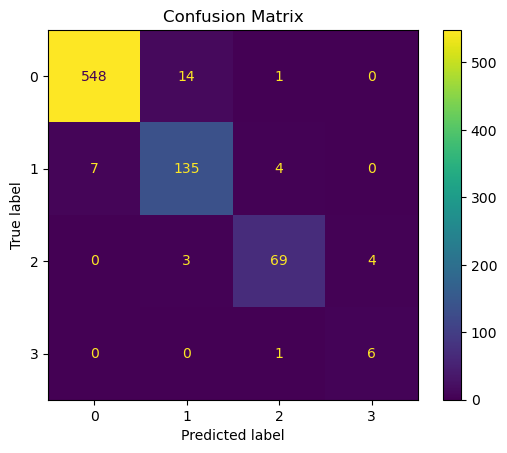

In [22]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

# Saving the LDA Model

In [23]:
# Save the best model pipeline
joblib.dump(best_pipeline, 'best_lda_model.pkl')

print("\nBest LDA model has been saved successfully.")


Best LDA model has been saved successfully.
